<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week5/LSTM_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from collections import Counter
from tqdm import tqdm

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [ ]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv'
df = pd.read_csv(url)
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
# Basic preprocessing
# Drop unnecessary columns and handle NaN values
df = df.dropna(subset=['Review Text', 'Rating'])




In [ ]:
# Convert ratings to binary sentiment (1-3 as negative, 4-5 as positive)
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

<ipython-input-9-f6b8a9553560>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)


In [ ]:
# Text preprocessing function
def preprocess_text(text):
    """Clean and preprocess the text data"""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text



In [ ]:
# Apply preprocessing to review text
df['Processed_Text'] = df['Review Text'].apply(preprocess_text)


<ipython-input-11-287461538c48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Processed_Text'] = df['Review Text'].apply(preprocess_text)


In [ ]:
# Split the data into training and testing sets
X = df['Processed_Text'].values
y = df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Build vocabulary from the training data
def build_vocab(texts, max_words=10000):
    # Count all words
    counter = Counter()
    for text in texts:
        counter.update(text.split())

    # Create vocabulary mapping
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, (word, _) in enumerate(counter.most_common(max_words-2), 2):
        word_to_idx[word] = idx

    return word_to_idx


In [ ]:
# Create vocabulary
max_words = 15000
max_len = 250
word_to_idx = build_vocab(X_train, max_words)
vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 12889


In [ ]:
# Convert text to numerical sequences
def text_to_sequence(text, word_to_idx, max_len):
    # Convert text to indices
    sequence = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in text.split()]

    # Truncate or pad sequence to max_len
    if len(sequence) > max_len:
        sequence = sequence[:max_len]
    else:
        sequence = sequence + [word_to_idx['<PAD>']] * (max_len - len(sequence))

    return sequence



In [ ]:
# Create sequences
X_train_seq = [text_to_sequence(text, word_to_idx, max_len) for text in X_train]
X_test_seq = [text_to_sequence(text, word_to_idx, max_len) for text in X_test]


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)


In [ ]:
# Create PyTorch Dataset
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
# Create DataLoaders
batch_size = 64
train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [ ]:
# Define the LSTM model
class LSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=True,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text shape: [batch size, max_len]
        embedded = self.embedding(text)
        # embedded shape: [batch size, max len, embedding dim]

        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch size, max len, hidden dim * 2] (bidirectional)
        # hidden shape: [n layers * 2 (bidirectional), batch size, hidden dim]

        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden shape: [batch size, hidden dim * 2]

        hidden = self.fc(hidden)
        hidden = torch.relu(hidden)
        hidden = self.dropout(hidden)
        # hidden shape: [batch size, hidden dim]

        output = self.output(hidden)
        # output shape: [batch size, output dim]

        return torch.sigmoid(output)


In [ ]:
# Initialize model parameters
embedding_dim = 128
hidden_dim = 128
output_dim = 1
n_layers = 2
dropout = 0.3


In [ ]:
# Create model instance
model = LSTMSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)


In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        acc = ((predictions == labels).sum().item()) / labels.size(0)

        # Accumulate metrics
        epoch_loss += loss.item()
        epoch_acc += acc

        # Store predictions and labels for overall metrics
        all_preds.extend(outputs.cpu().detach().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)

    # Convert to numpy arrays for sklearn metrics
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    # Calculate binary predictions (0 or 1)
    binary_preds = (all_preds > 0.5).astype(int)

    # Calculate additional metrics
    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    auc = roc_auc_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, precision, recall, f1, auc



In [ ]:
# Evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            acc = ((predictions == labels).sum().item()) / labels.size(0)

            # Accumulate metrics
            epoch_loss += loss.item()
            epoch_acc += acc

            # Store predictions and labels for overall metrics
            all_preds.extend(outputs.cpu().detach().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    epoch_loss /= len(data_loader)
    epoch_acc /= len(data_loader)

    # Convert to numpy arrays for sklearn metrics
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    # Calculate binary predictions (0 or 1)
    binary_preds = (all_preds > 0.5).astype(int)

    # Calculate additional metrics
    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    auc = roc_auc_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, precision, recall, f1, auc, all_preds, binary_preds, all_labels



In [ ]:
# Evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            acc = ((predictions == labels).sum().item()) / labels.size(0)

            # Accumulate metrics
            epoch_loss += loss.item()
            epoch_acc += acc

            # Store predictions and labels for overall metrics
            all_preds.extend(outputs.cpu().detach().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    epoch_loss /= len(data_loader)
    epoch_acc /= len(data_loader)

    # Convert to numpy arrays for sklearn metrics
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    # Calculate binary predictions (0 or 1)
    binary_preds = (all_preds > 0.5).astype(int)

    # Calculate additional metrics
    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    auc = roc_auc_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, precision, recall, f1, auc, all_preds, binary_preds, all_labels



In [ ]:
# Train the model
num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_acc, train_precision, train_recall, train_f1, train_auc = train_model(
        model, train_loader, criterion, optimizer, device
    )

    # Evaluation
    val_loss, val_acc, val_precision, val_recall, val_f1, val_auc, _, _, _ = evaluate_model(
        model, test_loader, criterion, device
    )

    # Record metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"\tTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"\tTrain Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
    print(f"\tTrain F1: {train_f1:.4f}, Train AUC: {train_auc:.4f}")
    print(f"\tVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"\tVal Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
    print(f"\tVal F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")

    # Check if we need to train more to reach 85% accuracy
    if train_acc < 0.85:
        print(f"Training accuracy ({train_acc:.4f}) is below 85%. Continuing training...")

    # Early stopping logic could be added here



Epoch 1/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 87.09it/s]


	Train Loss: 0.2215, Train Acc: 0.9113
	Train Precision: 0.9420, Train Recall: 0.9429
	Train F1: 0.9425, Train AUC: 0.9549
	Val Loss: 0.3004, Val Acc: 0.8758
	Val Precision: 0.9017, Val Recall: 0.9413
	Val F1: 0.9211, Val AUC: 0.9291
Epoch 2/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 83.24it/s]


	Train Loss: 0.1903, Train Acc: 0.9246
	Train Precision: 0.9509, Train Recall: 0.9513
	Train F1: 0.9511, Train AUC: 0.9667
	Val Loss: 0.3067, Val Acc: 0.8668
	Val Precision: 0.9437, Val Recall: 0.8794
	Val F1: 0.9104, Val AUC: 0.9312
Epoch 3/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 84.56it/s]


	Train Loss: 0.1657, Train Acc: 0.9366
	Train Precision: 0.9615, Train Recall: 0.9560
	Train F1: 0.9588, Train AUC: 0.9746
	Val Loss: 0.3157, Val Acc: 0.8799
	Val Precision: 0.9173, Val Recall: 0.9275
	Val F1: 0.9224, Val AUC: 0.9286
Epoch 4/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 83.12it/s]


	Train Loss: 0.1311, Train Acc: 0.9517
	Train Precision: 0.9724, Train Recall: 0.9648
	Train F1: 0.9686, Train AUC: 0.9837
	Val Loss: 0.3230, Val Acc: 0.8750
	Val Precision: 0.9285, Val Recall: 0.9074
	Val F1: 0.9178, Val AUC: 0.9258
Epoch 5/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 81.83it/s]


	Train Loss: 0.0983, Train Acc: 0.9656
	Train Precision: 0.9812, Train Recall: 0.9741
	Train F1: 0.9776, Train AUC: 0.9900
	Val Loss: 0.3893, Val Acc: 0.8768
	Val Precision: 0.9081, Val Recall: 0.9344
	Val F1: 0.9211, Val AUC: 0.9188
Epoch 6/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 82.63it/s]


	Train Loss: 0.0802, Train Acc: 0.9723
	Train Precision: 0.9842, Train Recall: 0.9798
	Train F1: 0.9820, Train AUC: 0.9934
	Val Loss: 0.4140, Val Acc: 0.8689
	Val Precision: 0.9081, Val Recall: 0.9229
	Val F1: 0.9154, Val AUC: 0.9133
Epoch 7/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 83.41it/s]


	Train Loss: 0.0627, Train Acc: 0.9787
	Train Precision: 0.9885, Train Recall: 0.9838
	Train F1: 0.9861, Train AUC: 0.9956
	Val Loss: 0.5215, Val Acc: 0.8700
	Val Precision: 0.8911, Val Recall: 0.9470
	Val F1: 0.9182, Val AUC: 0.9001
Epoch 8/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 83.80it/s]


	Train Loss: 0.0491, Train Acc: 0.9840
	Train Precision: 0.9909, Train Recall: 0.9883
	Train F1: 0.9896, Train AUC: 0.9973
	Val Loss: 0.5724, Val Acc: 0.8703
	Val Precision: 0.8949, Val Recall: 0.9421
	Val F1: 0.9179, Val AUC: 0.9034
Epoch 9/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 84.61it/s]


	Train Loss: 0.0317, Train Acc: 0.9896
	Train Precision: 0.9940, Train Recall: 0.9925
	Train F1: 0.9933, Train AUC: 0.9989
	Val Loss: 0.6426, Val Acc: 0.8771
	Val Precision: 0.9244, Val Recall: 0.9149
	Val F1: 0.9196, Val AUC: 0.9114
Epoch 10/10


Evaluating: 100%|██████████| 71/71 [00:00<00:00, 81.96it/s]

	Train Loss: 0.0269, Train Acc: 0.9913
	Train Precision: 0.9953, Train Recall: 0.9935
	Train F1: 0.9944, Train AUC: 0.9991
	Val Loss: 0.6496, Val Acc: 0.8678
	Val Precision: 0.8899, Val Recall: 0.9450
	Val F1: 0.9166, Val AUC: 0.9003


In [ ]:
# Final evaluation on test set
test_loss, test_acc, test_prec, test_recall, test_f1, test_auc, test_preds_proba, test_preds, test_labels = evaluate_model(
    model, test_loader, criterion, device
)


Evaluating: 100%|██████████| 71/71 [00:01<00:00, 65.57it/s]


In [ ]:
# Print final metrics
print("\nFinal Test Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")



Final Test Metrics:
Test Loss: 0.6496
Test Accuracy: 0.8678
Test Precision: 0.8899
Test Recall: 0.9450
Test F1 Score: 0.9166
Test AUC: 0.9003


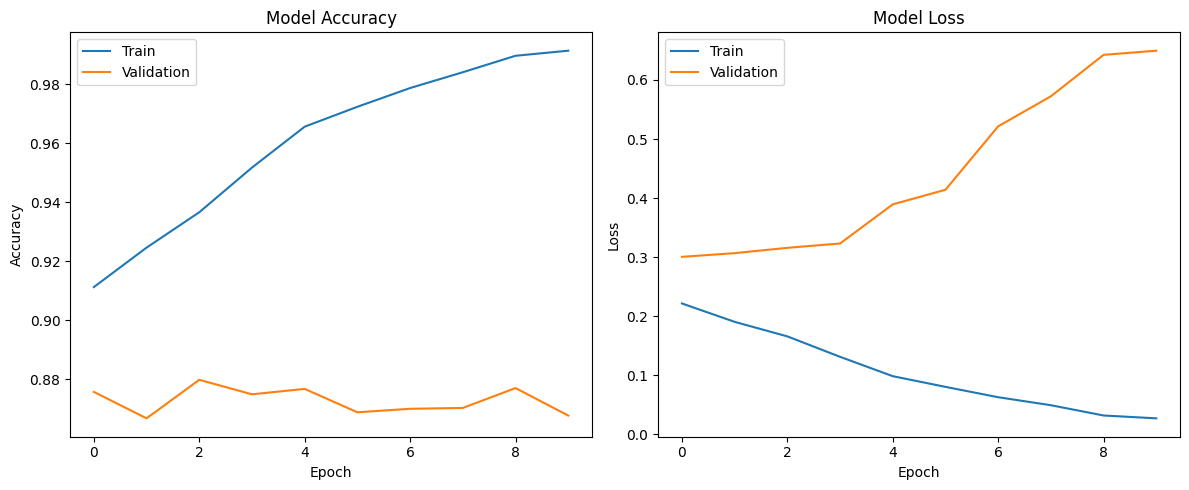

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))



Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.61      0.68      1039
         1.0       0.89      0.94      0.92      3490

    accuracy                           0.87      4529
   macro avg       0.83      0.78      0.80      4529
weighted avg       0.86      0.87      0.86      4529



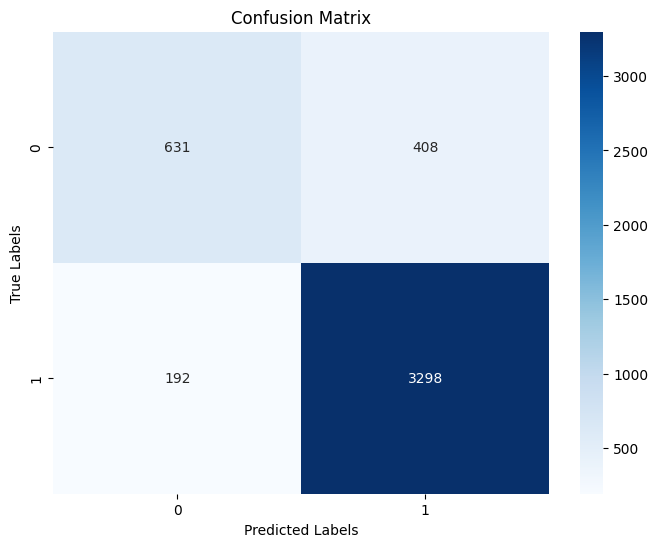

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


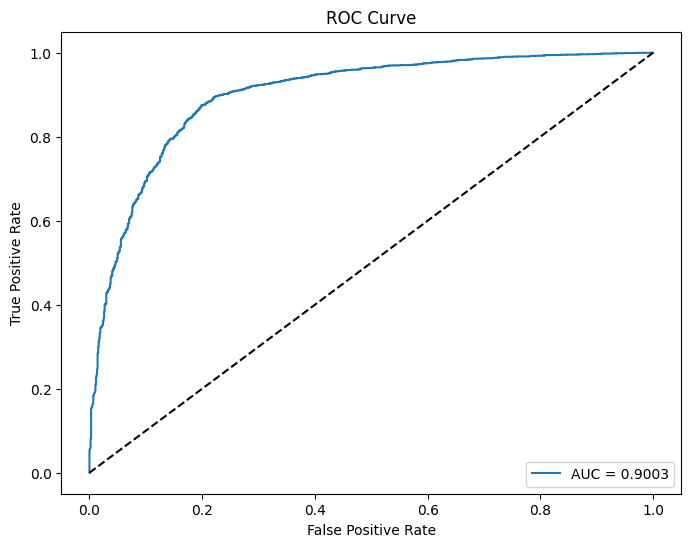

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_preds_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Save the trained model and vocabulary
torch.save({
    'model_state_dict': model.state_dict(),
    'word_to_idx': word_to_idx,
    'max_len': max_len
}, 'sentiment_lstm_model_pt.pt')

print("Model and vocabulary saved successfully!")


Model and vocabulary saved successfully!
